# Search Term to Classification Analysis

### Goal: 

- Built a model that gets reasonable micro & macro recall on a test set for the multiple class labels involved. 

### Metrics:

- Recall Overall & Across Classes
  - Micro
  - Macro

### Assumptions

- To figure out what the classes represented, I looked at a couple of the classes and came to the assumption that the classes represent the TYPE of item(s) that are being searched. 
  - I analyzed these 25 at a time.


### Issues

- Special characters are important. For example 3" means "three inches" and these can be entered in any number of ways like " '' " and "inch" and "in".
  - Way to fix this might be to use a custom tokenizer that learns what symbols are grouped together and then have the tokenizer combine the tokens togehter.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
from ydata_profiling import ProfileReport
import modin.pandas as pd
import modin.config as modin_config

modin_config.Engine.put("dask")

/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
conn = sql.connect('../data/grainger.db')
searches_class = pd.read_sql_query("""SELECT * FROM search_terms""", con=conn, dtype=object)

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [3]:
searches_class.describe()

,search_term,class
count,6128528,6128532
unique,5717834,485
top,products,ID_699068447
freq,442,283833


# Sample of Pandas Profiling - Doesn't Work With Large Dataset

In [4]:
# profile = ProfileReport(searches_class.sample(100000), minimal=True)
# profile.to_file('./outputs/profile/raw_data.html')

# Simple Exploration

In [5]:
searches_class.sample(25)

,search_term,class
4315014,label maker tape lebel lean and ge,ID_40650829
89468,honeywell he300,ID_832485429
2733476,deb stoko hvy2ldb,ID_706508931
2200793,battery powered co detectors with ul2075 listing,ID_564558024
1789219,wira screwdrivers,ID_833393046
248054,parker hydraulic reservoir,ID_121160841
1337863,the original steel toe muck boot co.,ID_332853642
2633256,30270or,ID_699945089
4764287,spri,ID_337225844
2528068,floor vibration springs,ID_548607428


In [6]:
searches_class[searches_class['class'] == 'ID_633057679'].sample(10)

,search_term,class
6094143,"resealable bags 10"" x 12""",ID_633057679
1572143,"3""l x 3""w standard reclosable poly bag",ID_633057679
1856191,mec foot sealer,ID_633057679
3144022,"6 x 8"" 6 mil anti-static poly bags",ID_633057679
632751,ziplock freezer bags,ID_633057679
4551770,bag tubing dispenser,ID_633057679
4303400,2.5 gallon ziploc bag,ID_633057679
784148,anti static bag,ID_633057679
3124368,reclosable bubble bags,ID_633057679
5201399,gallon zip loc bags,ID_633057679


### Class Exploration

In [7]:
# overall searches
class_size = searches_class.groupby('class') \
    .agg(search_term_count=('search_term', 'count')) \
    .sort_values('search_term_count', ascending=True)

# unique searches
class_size_unique = searches_class.groupby('class') \
    .agg(search_term_count=('search_term', 'nunique')) \
    .sort_values('search_term_count', ascending=True)

In [8]:
# all of the raw search texts are unique b/c sum of differences is zero
(class_size['search_term_count'] - class_size_unique['search_term_count']).apply(lambda x: abs(x)).sum()

0

Text(0.5, 0, 'Size of Classes')

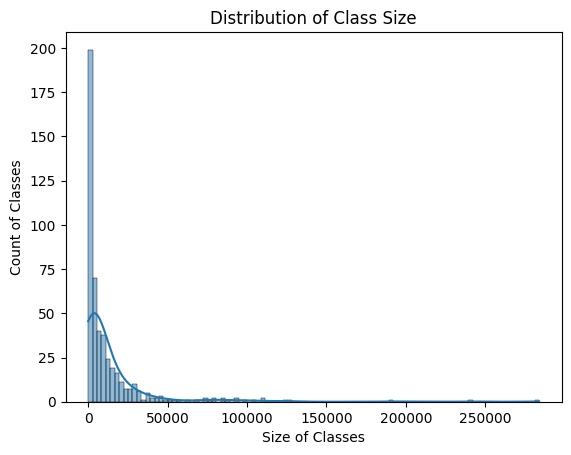

In [9]:
sns.histplot(class_size, legend=False, kde=True)
plt.title("Distribution of Class Size")
plt.ylabel("Count of Classes")
plt.xlabel("Size of Classes")

In [10]:
# classes vary from size of 283k search terms to one search term
class_size.describe()

,search_term_count
count,485.000000
mean,12636.140206
std,26215.519729
min,1.000000
25%,1248.000000
50%,4258.000000
75%,12274.000000
max,283833.000000


In [11]:
# classes which have only one entry
class_single_entry = class_size[class_size['search_term_count'] <= 3] # 1
display(class_single_entry)

# convert to list for removal
class_single_entry = class_single_entry.index.to_list()

,search_term_count
class,
ID_971210579,1
ID_817600387,1
ID_223719075,1
ID_82032374,1
ID_911331170,3


In [12]:
# remove the classes that have only one entry 
searches_class = searches_class[~searches_class['class'].isin(class_single_entry)]

In [13]:
# remove NAs from X 
searches_class = searches_class.dropna(subset=['search_term'])

### Exploration by Largest, Smallest Class

In [14]:
class_size

,search_term_count
class,
ID_971210579,1
ID_817600387,1
ID_223719075,1
ID_82032374,1
ID_911331170,3
...,...
ID_699945089,124288
ID_40650829,126986
ID_459833412,191248


In [15]:
searches_class[searches_class['class'] == 'ID_699068447'].head(50)

,search_term,class
103,monkey wrench,ID_699068447
105,crow bar,ID_699068447
129,hacksaw,ID_699068447
132,rope cutter,ID_699068447
148,axe pick,ID_699068447
164,come along,ID_699068447
168,pocket hole jig,ID_699068447
169,tile cutter,ID_699068447
201,a come along,ID_699068447
209,universal hub,ID_699068447


In [16]:
searches_class[searches_class['class'] == 'ID_946477099'].head(50)

,search_term,class
115,mhln,ID_946477099
153,nipple long,ID_946477099
219,g tubing,ID_946477099
394,pvc trap,ID_946477099
485,u bolt,ID_946477099
931,3/4 half,ID_946477099
1324,16x3,ID_946477099
1355,mueller metal,ID_946477099
1375,schedule 40 pipe,ID_946477099
1565,a lok,ID_946477099


In [17]:
searches_class[searches_class['class'] == 'ID_40650829'].head(50)

,search_term,class
5,tag mal,ID_40650829
300,the square sign in,ID_40650829
630,brother label maker,ID_40650829
1193,9 sided shape,ID_40650829
1214,striping bar,ID_40650829
1519,slow moving vehicle sign,ID_40650829
1857,label the eye,ID_40650829
2344,asterisk symbol,ID_40650829
2345,detour sign,ID_40650829
2472,brass color,ID_40650829


In [18]:
# how many entries have a special character in them
searches_class['contains_special_char'] = searches_class['search_term'].apply(lambda x: str(x).replace(' ', '').isalnum() == False)

In [19]:
# percent of total entries that contain special characters
searches_class['contains_special_char'].sum() / len(searches_class)

0.2830798817528732

In [20]:
# by classes that contain special characters
special_characters_class = searches_class.groupby('class').agg(n_special_chars=('contains_special_char', 'sum'), n_entries=('contains_special_char', 'count'))
special_characters_class = special_characters_class.sort_values('n_special_chars', ascending=True)
special_characters_class['class_pct_special_chars'] = (special_characters_class['n_special_chars'] / special_characters_class['n_entries'])*100
total_entries = special_characters_class['n_entries'].sum()
special_characters_class['class_total_pct_special_chars'] = (special_characters_class['n_special_chars'] / total_entries)*100

In [21]:
# 22% of each class, on average, contains special characters
special_characters_class.describe()

,n_special_chars,n_entries,class_pct_special_chars,class_total_pct_special_chars
count,480.000000,480.000000,480.000000,480.000000
mean,3614.293750,12767.752083,22.749587,0.058975
std,10324.166782,26320.022781,13.354090,0.168461
min,0.000000,4.000000,0.000000,0.000000
25%,199.750000,1282.250000,13.390248,0.003259
50%,888.500000,4423.000000,18.796025,0.014498
75%,2979.750000,12352.500000,28.221045,0.048621
max,153662.000000,283833.000000,71.289971,2.507326


In [22]:
special_characters_class.columns.to_list()

['n_special_chars',
 'n_entries',
 'class_pct_special_chars',
 'class_total_pct_special_chars']

2023-07-06 03:06:35,112 - distributed.worker - ERROR - Exception during execution of task lambda-b6df6ca7b3924a6463707a655a59d114.
Traceback (most recent call last):
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/zict/buffer.py", line 184, in __getitem__
    return self.fast[key]
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/zict/common.py", line 127, in wrapper
    return func(*args, **kwargs)
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/zict/lru.py", line 117, in __getitem__
    result = self.d[key]
KeyError: 'apply_list_of_funcs-f1ecbb03-1e4d-4e9e-b5b9-d873ad17ddee'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/home/programming/miniconda3/envs/gr

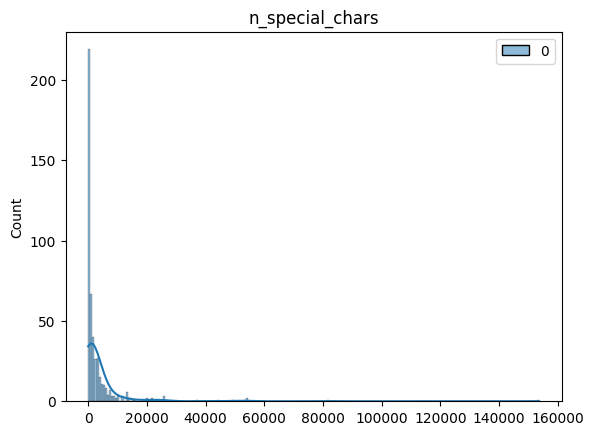

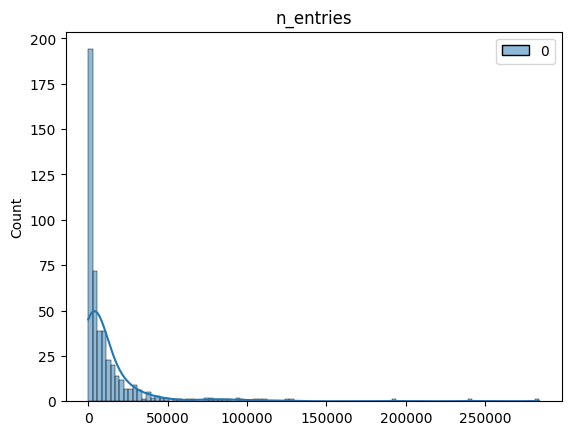

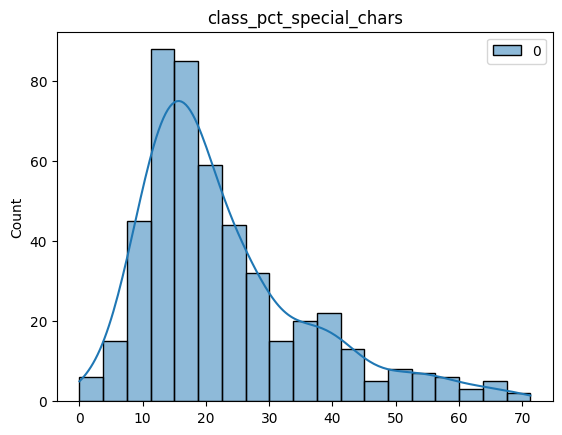

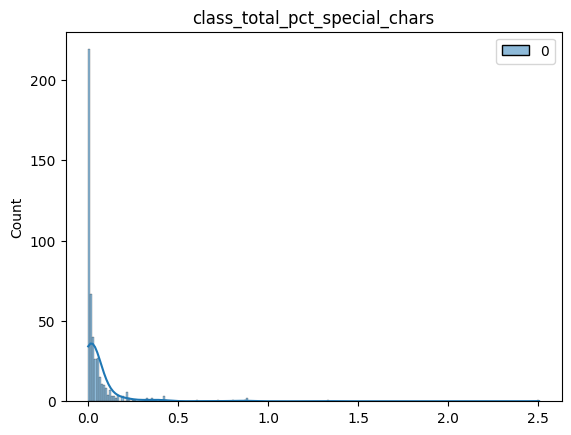

In [23]:
for col in special_characters_class.columns.to_list():
    sns.histplot(special_characters_class[[col]], kde=True)
    plt.title(col)
    plt.show()

# Break Data into Training and Testing Split

In [24]:
# columns of interest
x_col = 'search_term'
y_col = 'class'

from preprocess import split_data, encode_classes, get_stopwords
from preprocess import set_count_vectorizer
from preprocess import SearchAnalyzer
from utils import save_pickle_file

stop_words = get_stopwords()

x_train, x_test, y_train, y_test = split_data(
    x_data=searches_class[x_col],
    y_data=searches_class[y_col], 
    stratify=searches_class['class'], 
    test_size=0.2)

y_encodings, y_decodings = encode_classes(searches_class[y_col].unique())

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
2023-07-06 03:07:19,967 - distributed.worker - WARNING - Could not find data: {'function-bd05395d0282407b911714a5281836a7': ['tcp://127.0.0.1:38959', 'tcp://127.0.0.1:44931', 'tcp://127.0.0.1:33899']} on workers: [] (who_has: {'function-bd05395d0282407b911714a5281836a7': ['tcp://127.0.0.1:38959', 'tcp://127.0.0.1:44931', 'tcp://127.0.0.1:33899']})
2023-07-06 03:07:19,969 - distributed.scheduler - WARNING - Worker tcp://127.0.0.1:43913 failed to acquire keys: {'function-bd05395d0282407b911714a5281836a7': ('tcp://127.0.0.1:38959', 'tcp://127.0.0.1:44931', 'tcp://127.0.0.1:33899')}
2023-07-06 03:07:20,697 - distributed.worker - WARNING - Could not find data: {'function-cf18b1999fb74f6eb5f577c5109207c5': ['tcp://127.0.0.1:41835', 'tcp://127.0.0.1:43913', 'tcp://127.0.0.1:46579']} on workers: [] (who_has: {'function-cf18b1999fb74f6eb5f577c5109207c5': ['tcp://127.0.0.1:41835',

In [ ]:
# send data to the database
x_train.to_sql('x_train_og', con=conn, if_exists='replace')
x_test.to_sql('x_test_og', con=conn, if_exists='replace')

y_train.to_sql('y_train_og', con=conn, if_exists='replace')
y_test.to_sql('y_test_og', con=conn, if_exists='replace')

In [26]:
# save out encoding and decodings as pickle files
save_pickle_file(y_encodings, '../data/y_encodings.pkl')
save_pickle_file(y_decodings, '../data/y_decodings.pkl')

True

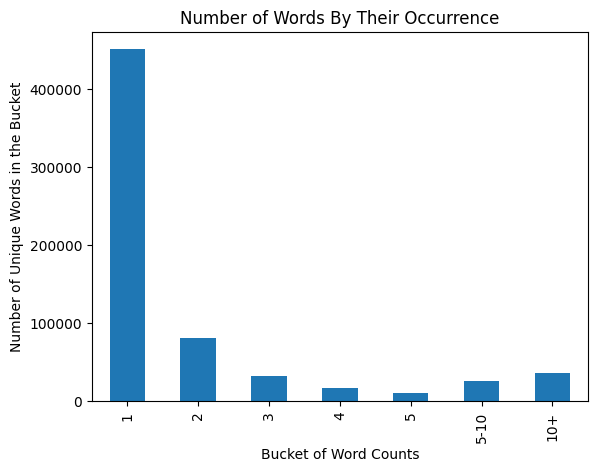

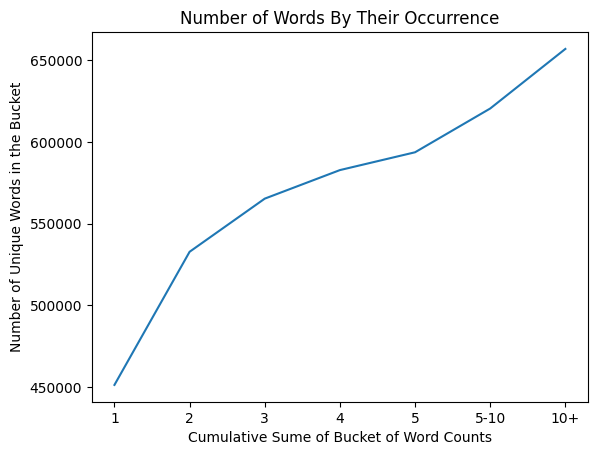

Total Vocab Size: 656981


,bucket_count,Pct of Vocab Covered
count_bucket,,
1,451184,69.0
2,81546,12.0
3,32553,5.0
4,17483,3.0
5,10911,2.0
5-10,26812,4.0
10+,36492,6.0


In [27]:
analyzer = SearchAnalyzer(
    corpus=x_train,
    stopwords=stop_words
)
analyzer.get_word_occur(ngram_range=(1,1))
analyzer.bin_counts() # standard settings
analyzer.visualize() # also return the dataframe

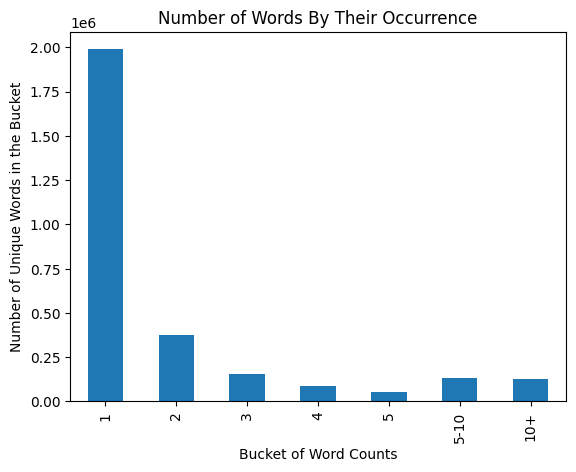

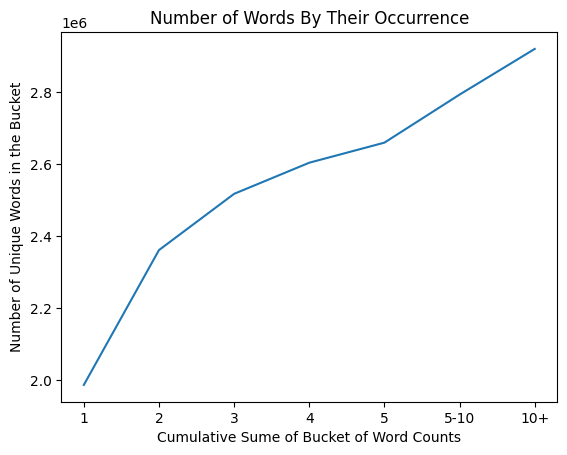

Total Vocab Size: 2920657


,bucket_count,Pct of Vocab Covered
count_bucket,,
1,1987310,68.0
2,374569,13.0
3,156265,5.0
4,86421,3.0
5,55758,2.0
5-10,133470,5.0
10+,126864,4.0


In [28]:
# do analysis again with different ngram range
analyzer.get_word_occur(ngram_range=(2,2))
analyzer.bin_counts() # standard settings
analyzer.visualize() # also return the dataframe

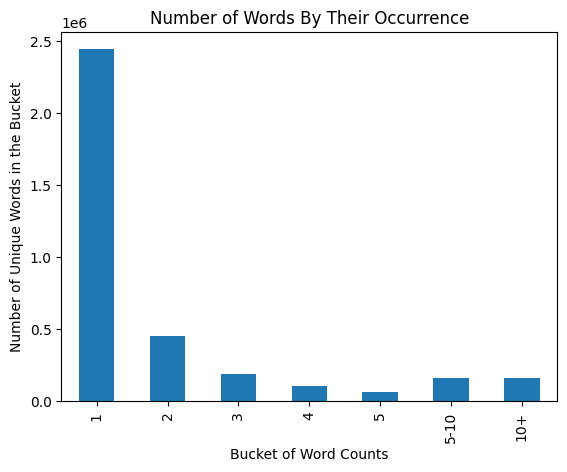

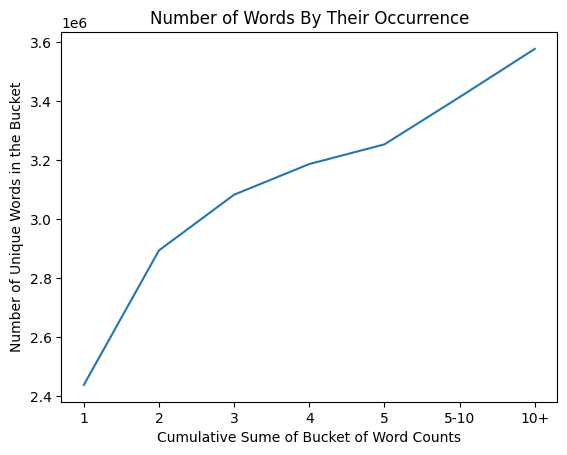

Total Vocab Size: 3577638


,bucket_count,Pct of Vocab Covered
count_bucket,,
1,2438494,68.0
2,456115,13.0
3,188818,5.0
4,103904,3.0
5,66669,2.0
5-10,160282,4.0
10+,163356,5.0


In [29]:
# do analysis again with different ngram range
analyzer.get_word_occur(ngram_range=(1,2))
analyzer.bin_counts() # standard settings
analyzer.visualize() # also return the dataframe

In [30]:
del analyzer

# Count Vectorizer With Limits

In [31]:
cv = set_count_vectorizer(
    stop_words=stop_words,
    min_df=2,
    ngram_range=(1,2)
)

x_train_cvec = cv.fit_transform(list(x_train.values))
x_test_cvec = cv.transform(x_test)

save_pickle_file(cv, '../data/count_vectorizer_obj.pkl')
save_pickle_file(x_train_cvec, '../data/x_train_vectorized.pkl')
save_pickle_file(x_test_cvec, '../data/x_test_vectorized.pkl')

True

In [32]:
# encode the y train list for processing
y_train_encode = [y_encodings[i] for i in y_train.to_list()]
y_test_encode = [y_encodings[i] for i in y_test.to_list()]

save_pickle_file(y_train_encode, '../data/y_train_encode.pkl')
save_pickle_file(y_test_encode, '../data/y_test_encode.pkl')

True